# Fourier Transform Spectroscopy

The idea of this tutorial is to show how one can use PyMoDAQ data objects to construct a physical simulation: here to explore the temporal/spectral properties of coherent light pulses such as a laser. We will define the pulse in the spectral domain and get it in the time domain, via Fourier Transform. We will see how the spectral phase modify the temporal shape of a pulse

The idea is to simulate a temporal pulse from its spectral properties, linear phase, quadratic phase, ...

We will:

* construct our pulse in the spectral domain
* calculate its temporal field
* extract some relevant physical quantities and compare them to analytical expressions

## Pulses

Lets define our temporal pulses on a regular temporal grid (Axis) and some typical physical values

In [1]:
%gui qt
import pymodaq_gui  # allows plotting using the Qt backend
from pymodaq_data import Q_
import numpy as np

print(Q_)

Nt = 2**10 # number of point on the grid

lambda0 = Q_(800, 'nm')  # typical central wavelength of a pulse (but wavelength is non linar in energy...)
f0 = lambda0.to('PHz', 'spectroscopy')
omega0 = (2 * np.pi * f0).to('rad/fs')
T0 = (1 / f0).to('fs')

Nperiod = 100

print(f'{T0}')
print(f0.magnitude)
print(f0.units)
print(f'omega0: {omega0}')

<class 'pint.Quantity'>
2.668512761585217 fs
0.3747405724999999
PHz
omega0: 2.354564459136066 rad / fs


In [2]:
f0 = lambda0.to('PHz')

DimensionalityError: Cannot convert from 'nanometer' ([length]) to 'petahertz' (1 / [time])

### Units in Python: the pint module and quantity?

We used and saw above the introduction of a Quantity object that has many usefull properties when dealing with physical quantities, for instance see how we converted from wavelength in nanometer to frequency. Try out without the *spectroscopy* context:

In [3]:
T0.m_as('s')

2.668512761585217e-15

PyMoDAQ in v5 is embarking upon using units compatibility in all data objects. This has advantages (automatic unit conversion upon operation between objects with compatible units) but also some restrictions (you cannot do any operation if their units are incompatible...well except if you specify your objects to be dimensionless... but be aware of unit incompatibility)

In [4]:
from pymodaq_data.data import Axis, DataRaw
import pymodaq_gui

dwa_m = DataRaw('length in meter', units='m', data=[np.array([1, 2, 3])])
dwa_m_dimensionless = DataRaw('length in meter', units='', data=[np.array([1, 2, 3])])

dwa_mm = DataRaw('length in millimeter', units='mm', data=[np.array([1, 2, 3])])
dwa_mm_dimensionless = DataRaw('length in millimeter', units='', data=[np.array([1, 2, 3])])

print((dwa_m + dwa_mm).quantities[0])
print((dwa_mm + dwa_m).quantities[0])

[1.001 2.002 3.003] m
[1001.0 2002.0 3003.0] mm


In [5]:
(dwa_mm + dwa_m).units_as('m').quantities

[<Quantity([1.001 2.002 3.003], 'meter')>]

In [6]:
print((dwa_m_dimensionless + dwa_mm_dimensionless).quantities[0])
print((dwa_mm_dimensionless + dwa_m_dimensionless).quantities[0])

[2 4 6]
[2 4 6]


In [7]:
print((dwa_m + dwa_mm_dimensionless).quantities[0])

DimensionalityError: Cannot convert from 'dimensionless' (dimensionless) to 'meter' ([length])

In [8]:
# you can play around:



In [9]:

time_axis = Axis('time', data=np.linspace(-Nperiod/2 * T0, Nperiod/2 * T0, Nt))
print(time_axis)
print(time_axis.units)
print(time_axis.data)
print(time_axis.offset)
print(time_axis.scaling)

Axis: <label: time> - <units: fs> - <index: 0>
fs
None
-133.42563807926084 fs
0.26085168734948355 fs


In [10]:
time_axis.get_data()

Magnitude,[-133.42563807926084 -133.16478639191135 -132.90393470456186 ... 132.90393470456186 133.16478639191135 133.42563807926084]
Units,fs


In [11]:
time_axis.as_dwa()

<DataRaw: time <u: fs> <len:1> (|1024)>

In [12]:
time_axis.as_dwa().plot('qt')

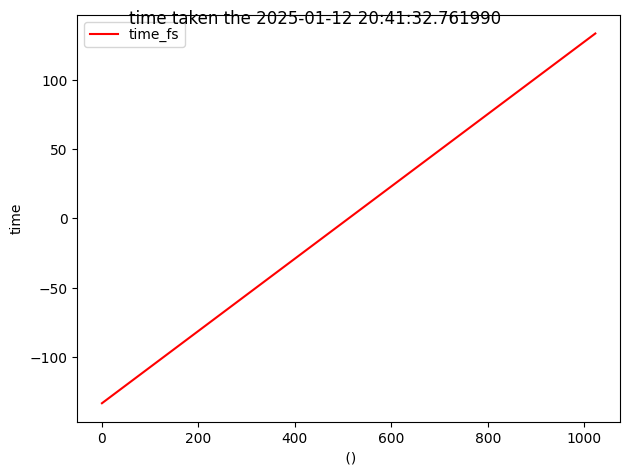

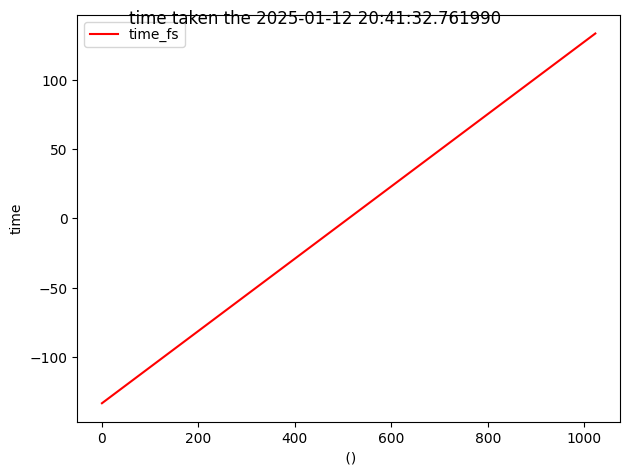

In [13]:
time_axis.as_dwa().plot('matplotlib')

Let's introduce now the description of a pulse having a quadratic phase:

![chirp_pulse](simulation_data/quadratic_phase.png)

In [14]:
dt0 = Q_(10, 'fs')  # FT limited duration with dt0dw=1/2
domega = 1/( 2* dt0)
phi2 = Q_(300, 'fs**2')  # quadratic phase

dtc = dt0 * np.sqrt(1 + phi2**2/(4*dt0**4))  # quadratic phase impact on the final pulse duration
print(f'dtc: {dtc}')

dtc: 18.027756377319946 fs


In [15]:
# let's define the laser pulse in the spectral domain
from pymodaq_utils import math_utils as mutils
omega_grid, time_grid = mutils.ftAxis_time(Nt, Nperiod * T0)

In [16]:
omega_grid


Magnitude,[-12.043597208480978 -12.020051563889618 -11.996505919298256 ... 11.996505919298258 12.02005156388962 12.043597208480978]
Units,1/fs


In [ ]:
time_axis = Axis(...) #fill in from the time_grid quantity
omega_axis = Axis(...) # fill in from the omega_grid quantity

In [17]:
# let's define the laser pulse in the spectral domain
from pymodaq_utils import math_utils as mutils
omega_grid, time_grid = mutils.ftAxis_time(Nt, Nperiod * T0)

time_axis = Axis('time', units=str(time_grid.units), data=time_grid.magnitude) #fill in from the time_grid quantity
omega_axis = Axis.from_quantity(omega_grid, 'omega') # fill in from the omega_grid quantity



In [18]:
print(omega_axis) #angular frequency should be expressed in rad/s
print(time_axis)

Axis: <label: omega> - <units: 1 / fs> - <index: 0>
Axis: <label: time> - <units: fs> - <index: 0>


In [27]:
viewer1D = omega_axis.as_dwa(True).plot('qt')

In [ ]:
omega_axis = Axis('omega', units=f'rad*{str(omega_grid.units)}', data=omega_grid.magnitude).to_reduced_units()

In [ ]:
print(omega_axis) #angular frequency should be expressed in rad/s
print(time_axis)

In [28]:
viewer1D.show_data(time_axis.as_dwa())

In [29]:
# let's now define our pulse in the spectral domain:

dwa_field_omega = np.exp(-(omega_axis.as_dwa(True) - omega0)**2 / (4 * domega**2)) * np.exp(1j * phi2 / 2 * (omega_axis.as_dwa(True) - omega0)**2)
dwa_field_omega.real().plot('qt')

#several issues: omega is an Axis object, no proper labels and dwa_field is complex?

In [30]:
np.real(dwa_field_omega).plot('qt')

In [31]:
# let's now define our pulse in the spectral domain:
dwa_field_omega = np.exp(-(omega_axis.as_dwa(True) - omega0)**2 / (4 * domega**2)) * np.exp(1j * phi2 / 2 * (omega_axis.as_dwa(True) - omega0)**2)
dwa_field_omega.labels = ['spectral field']
dwa_field_omega.abs().plot('qt')

#several issues? omega is an Axis object and dwa_field is complex?

In [32]:
# let's calculate the temporal field

dwa_field_time = dwa_field_omega.ift()
dwa_field_time.real().plot("qt")

In [33]:
from pymodaq_data.data import DataToExport
dte = DataToExport('bundled', data=[time_axis.as_dwa(), omega_axis.as_dwa()])
dte.plot('qt')

In [34]:
# let's calculate the temporal field

dwa_field_time = dwa_field_omega.ift(axis_label='time', axis_units='fs', labels=['temporal field'])
dwa_field_time.real().plot("qt")

We have calculated the field with a zero quadratic phase, try now to run back the code with some other value for phi2: 100fs^2, 1000fs^2 ... what's happening?

In [36]:
# ploting on separated viewers
from pymodaq_data.data import DataToExport, DataDim

dte_pulses = DataToExport('pulses', data=[dwa_field_omega.abs(),dwa_field_omega.angle(), dwa_field_time.real()], labels=['omega', 'time'])
viewer_dispatch = dte_pulses.plot('qt')

In [ ]:
(slice(1.9970066962354072, 2.724614297913137, None),)

It's nice but difficult to see the area where the phase is defined let's extract this out of our data, using ROI and slice

![dispatcher](simulation_data/viewer_dispatch_clipboard.png)

In [37]:
(slice(1.8443394613904172, 2.824921311314552, None),)  #these are coordinates on the axis not index!!!

dwa_omega_sliced.isig[(slice(-49.45596754790016, 49.45596754790017, None),)]
dwa_omega_sliced.inav[(slice(-49.45596754790016, 49.45596754790017, None),)]
dwa_omega_sliced.vsig[(slice(-49.45596754790016, 49.45596754790017, None),)]
dwa_omega_sliced.vnav[(slice(-49.45596754790016, 49.45596754790017, None),)]
(slice(-49.45596754790016, 49.45596754790017, None),)

NameError: name 'dwa_omega_sliced' is not defined

In [39]:
dwa_omega_sliced = dwa_field_omega.vsig[(slice(1.8443394613904172, 2.824921311314552, None),)]

dte_pulses = DataToExport('pulses', data=[dwa_omega_sliced.abs(),dwa_omega_sliced.angle().unwrap(), dwa_field_time.real()], labels=['omega', 'time'])
dte_pulses.plot('qt')


## Now let's try to fit the temporal pulse and retrieve the chirped duration

In [40]:
mini = np.min(dwa_field_time.abs())
mini.value()

4.336808689942018e-19

In [41]:
from pymodaq_utils import math_utils as mutils

def gaussian_fit(time, offset, amp, t0, dt):
    return offset + amp * np.exp(-(time - t0)**2 / (4*dt**2))

t0_ini, dt_ini = dwa_field_time.abs().moment()

dwa_fit = dwa_field_time.abs().fit(gaussian_fit, initial_guess=[np.min(dwa_field_time.abs()).value(),
                                                                np.max(dwa_field_time).value()-np.min(dwa_field_time).value(),
                                                                t0_ini.value(),
                                                                dt_ini.value()])
print(dwa_fit.fit_coeffs)
dwa_comparison = DataRaw('fit', data=[dwa_field_time.abs()[0], dwa_fit[0]+0.001],
                        axes=dwa_field_time.axes,
                        labels=['simul', 'fit'])
dwa_comparison.plot('qt')

print(f'dtc fit: {dwa_fit.fit_coeffs[0][3]} fs')
print(f'dtc theory: {dtc}')

[array([-5.39463142e-12,  5.47511891e-03,  1.30298475e-01,  1.80277564e+01])]
dtc fit: 18.027756402519874 fs
dtc theory: 18.027756377319946 fs


In [42]:
from pymodaq_data.h5modules.data_saving import H5SaverLowLevel, DataToExportSaver
dwa_spectrum = DataRaw('spectral', data=[(dwa_omega_sliced.abs()**2)[0], dwa_omega_sliced.angle().unwrap()[0]],
                       axes=dwa_omega_sliced.axes, labels=['intensity', 'phase'])
dte_to_save = DataToExport('tobesaved', data=[dwa_spectrum, dwa_fit, dwa_field_time.real()])

with DataToExportSaver('ft_pulses2.hdf5') as dte_saver:
    dte_saver.add_data('/', dte_to_save)

Ok let's have a look at this with the h5browser!

and let's open the file here now:

In [44]:
from pymodaq_data.h5modules.data_saving import DataLoader

with DataLoader('ft_pulses2.hdf5') as dwa_loader:
    dwa = dwa_loader.load_data('/Data1D/CH00/Data00')
dwa.plot('qt')

but if you don't know what data to load:

In [45]:
loader = DataLoader('ft_pulses2.hdf5')

for node in loader.walk_nodes('/'):
    print(node)

/ (GROUP) 'PyMoDAQ file'
/Data1D (GROUP) ''
/RawData (GROUP) 'Data from PyMoDAQ modules'
/Data1D/CH00 (GROUP) 'omega_subtract_power_negative_divide_exp_multiply_absolute_fit'
/Data1D/CH01 (GROUP) 'omega_subtract_power_negative_divide_exp_multiply_real'
/Data1D/CH02 (GROUP) 'spectral'
/RawData/Logger (VLARRAY) ''
/Data1D/CH00/Axis00 (CARRAY) 'time'
/Data1D/CH00/Axis01 (CARRAY) 'time'
/Data1D/CH00/Data00 (CARRAY) 'omega_subtract_power_negative_divide_exp_multiply_absolute_fit'
/Data1D/CH00/Data01 (CARRAY) 'omega_subtract_power_negative_divide_exp_multiply_absolute_fit'
/Data1D/CH01/Axis00 (CARRAY) 'time'
/Data1D/CH01/Axis01 (CARRAY) 'time'
/Data1D/CH01/Data00 (CARRAY) 'omega_subtract_power_negative_divide_exp_multiply_real'
/Data1D/CH01/Data01 (CARRAY) 'omega_subtract_power_negative_divide_exp_multiply_real'
/Data1D/CH02/Axis00 (CARRAY) 'omega'
/Data1D/CH02/Axis01 (CARRAY) 'omega'
/Data1D/CH02/Data00 (CARRAY) 'spectral'
/Data1D/CH02/Data01 (CARRAY) 'spectral'
/Data1D/CH02/Data02 (CARRAY)

In [ ]:
loader.load_data('/Data1D/CH02/Data00').plot('qt')

In [ ]:
loader.close_file()

Well that's it for this practical around using the Data Objects within pymodaq. Make sure to let me know if/when you use that in your data analysis!